# User Guide

This jupyter notebook can be found
[here](https://gitlab.cern.ch/gdl4hep/montetracko/-/blob/master/guide/guide.ipynb)
under the `Guide` folder of the repository.

## Introduction
MonteTracko is a Python library designed for analyzing the performance of tracking
algorithms. The library offers tools for loading tracks, matching them to particles,
and evaluating tracking performance using various metrics.

This guide aims to provide a comprehensive introduction to using MonteTracko.
We will walk through the main functionalities of the library with examples using
sample data located inside the data folder. The data consists of 100 events
of min-bias LHCb data in run 3.



In [1]:
import os
import pprint
import pandas as pd
import montetracko as mt

## Load

### Load truth information

To start working with MonteTracko, it is necessary to load truth information.
This involves loading two DataFrames:

- **Hits**: contains  a mapping of hit ID to particle ID
- **Particles**: contains information about the particles, such as kinetic, identity, reconstruction properties

These DataFrames are necessary for matching tracks to particles and
evaluating the tracking algorithm's performance on specific categories.


#### Dataframe of hits

The file `data/xdigi2csv/hits_velo.parquet.lz4` contains a DataFrame of hits that has 3 columns:

- `event`: an event ID
- `lhcbid`: a hit ID
- `mcid`: a particle ID

A hit in this DataFrame is identified by its event ID and hit ID.
The `mcid` column provides information about the particle that generated the hit.

In [14]:
df_hits_particles = pd.read_parquet(
    "data/xdigi2csv/hits_velo.parquet.lz4",
    columns=["run", "event", "lhcbid", "mcid"],
)

print(df_hits_particles)

             run    event     lhcbid  mcid
0       17238245  7113793  537320925  3882
1       17238245  7113793  536882314  3881
2       17238245  7113793  537013501  2329
3       17238245  7113793  537032237   686
4       17238245  7113793  537017348  4422
...          ...      ...        ...   ...
214593  17234361  6461290  724649164  3917
214594  17234361  6461290  724649164  3928
214595  17234361  6461290  724662848  4771
214596  17234361  6461290  724982030  3111
214597  17234361  6461290  791998579  5886

[214598 rows x 4 columns]


In this dataframe, a hit that is not associated with any particle is identified as a
fake hit, which has a `mcid` value equal to `-1`.

In [5]:
df_hits_particles[df_hits_particles["mcid"] == -1]

event     lhcbid  mcid
9       7113793  537002098    -1
35      7113793  538209002    -1
70      7113793  539104944    -1
79      7113793  539371713    -1
103     7113793  540180243    -1
...         ...        ...   ...
214485  6461290  588799686    -1
214490  6461290  588867523    -1
214513  6461290  589455077    -1
214518  6461290  589495737    -1
214524  6461290  589596022    -1

[28920 rows x 3 columns]

It is worth noting that a hit may be associated with several particles,
so a given hit may have several rows in the dataframe.

In [6]:
print("Hits that are associated with more than 1 particle:")
print(
    df_hits_particles[
        df_hits_particles.duplicated(subset=["event", "lhcbid"], keep=False)
    ]
)

proportion = len(
    df_hits_particles[df_hits_particles.duplicated(subset=["event", "lhcbid"])]
) / len(df_hits_particles.drop_duplicates(subset=["event", "lhcbid"]))

print(f"\nProportion of hits that have duplicates: {proportion:.2%}")


Hits that are associated with more than 1 particle:
          event     lhcbid  mcid
97      7113793  740848425   690
98      7113793  740848425   691
169     7113793  542660351  4437
170     7113793  542660351  4438
171     7113793  542660351  4439
...         ...        ...   ...
214465  6461290  588359395  3876
214560  6461290  590450904  3872
214561  6461290  590450904  3876
214593  6461290  724649164  3917
214594  6461290  724649164  3928

[5750 rows x 3 columns]

Proportion of hits that have duplicates: 1.45%


#### Dataframe of particles

`data/xdigi2csv/mc_particles.parquet.lz4` contains truth information about the particles.
Each particle in this dataframe is identified by

- its event ID (`event` column)
- its particle ID (`mcid` column)

The dataframe provides a variety of information about each particle, including:

- Kinematical information such as momentum (`p`), transverse momentum ($p_T$, `pt`),
pseudo-rapidity (`eta`), and z-position of the origin vertex (`vz`).
- Information about the particle identity, such as whether the particle comes from
a meson with a b-quark or s-quark (`from_bdecay`, `from_sdecay`)
and the particle's PDGID (`pid`).
- Information about reconstruction, including whether the particle is reconstructible
in the Velo or in the SciFi (`has_velo`, `has_scifi`), and the number of hits the
particle has in the velo (`nhits_velo`).

Note that the particle ID (`mcid` column) can be used to link particles to their
corresponding hits in the `df_hits` dataframe.


In [8]:
df_particles = pd.read_parquet("data/xdigi2csv/mc_particles.parquet.lz4")
print(df_particles)

            run    event  mcid  pid          p          pt       eta  \
0      17238245  7113793   508  211  11670.000   519.48700 -3.804590   
1      17238245  7113793   542  211   8809.930   310.99300 -4.036700   
2      17238245  7113793   543 -321   7661.760   412.87900 -3.613260   
3      17238245  7113793   546 -211    402.619    89.87360 -2.180040   
4      17238245  7113793   549  321   6793.020   497.42900 -3.306000   
...         ...      ...   ...  ...        ...         ...       ...   
88969  17234361  6461290  8050  211   2094.280  1534.89000 -0.829746   
88970  17234361  6461290  8057 -211    650.975   148.12100  2.160390   
88971  17234361  6461290  8058   11     10.038     1.65846  2.486730   
88972  17234361  6461290  8063  211   1284.130   777.04000 -1.087990   
88973  17234361  6461290  8065  211   5426.060  1127.17000 -2.253680   

            phi  charge  mother_mcid  ...  from_cdecay  from_sdecay  \
0     -2.023580       1           -1  ...        False        Fa

### Load the tracks

To use the MonteTracko library, tracks must be stored in a DataFrame with 3 columns:

- the event ID (`event` column)
- the track ID (`track` column)
- the hit ID (`lhcbid` column)

A track is identified by an event ID and track ID.

However, the tracks saved in `data/velo_tracks` are in a different format.
There is one CSV file per event, and the event ID, defined as `run * 10**9 + event`,
is the CSV file name.

Each CSV file contains a header and each subsequent row represents
a list of hit IDs (`lhcbid`) belonging to a given track, padded with zeros.
These files were obtained from the Allen Velo tracking algorithm.

```
"plane0","plane1","plane2","plane3","plane4","plane5","plane6","plane7","plane8","plane9","plane10","plane11","plane12","plane13","plane14","plane15","plane16","plane17","plane18","plane19","plane20","plane21","plane22","plane23","plane24","plane25"
589926980,587824729,719939690,583619453,581510823,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
589930317,587827296,585724531,583621509,581512873,579404237,711517417,776523771,572716279,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
589932620,587830364,585727851,583625595,581517978,579410361,577306065,575203552,573103848,638113007,568904439,566426364,0,0,0,0,0,0,0,0,0,0,0,0,0,0
656998372,587788013,585686518,583203567,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...
```
To use these tracks with MonteTracko, they must be converted into a DataFrame using 
the `montetracko.TrackHandler` class.

Before calling this function, it is necessary to define configuration parameters
that fit your specific case. The default configuration is as follows:

In [10]:
pprint.pprint(mt.config.configdef.param_to_default)

{'aliases': {'event_id': 'event_id',
             'hit_id': 'hit_id',
             'n_hits_particle': 'n_hits_particle',
             'particle_id': 'particle_id',
             'track_id': 'track_id'},
 'fake_particle_id': -1,
 'ncores': 20}


In our case, we use `event`, `lhcbid`, `mcid` and `track` as column names.
 The `n_hits_particle` column in the `df_particles` dataframe corresponds to
 the number of hits for a given particle.
 If this column is not present in the `df_particles` dataframe,
 it will be computed automatically during the relevant stage.

The `fake_particle_id` parameter is set to -1 to identify fake hits
in the `df_hits_particles` dataframe, and doesn't need to be changed.

The `ncores` parameter sets the maximum number of threads that can run
in parallel and is set to the number of cores in your computer by default.

In [15]:
config_params = {
    "aliases": {
        "event_id": "event",
        "track_id": "track",
        "hit_id": "lhcbid",
        "particle_id": "mcid",
    },
}


To load all the CSV files under `data/velo_tracks/*.csv`,
you can use the `montetracko.TrackHandler` object.

This can be done using the following code:

In [16]:
trackHandler = mt.TrackHandler.from_padded_csv(
    "data/velo_tracks/*.csv",
    config=config_params,
)
df_tracks_hits = trackHandler.dataframe

  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
print(df_tracks_hits)

                  event  track     lhcbid
0     17238245007113881      0  657007798
1     17238245007113881      0  587798465
2     17238245007113881      0  585697996
3     17238245007113881      0  583598039
4     17238245007113881      0  581494509
...                 ...    ...        ...
1750  17238245007113873    291  540189938
1751  17238245007113873    291  538093033
1752  17238245007113873    292  542280701
1753  17238245007113873    292  540183286
1754  17238245007113873    292  538086128

[152985 rows x 3 columns]


In our case, the `event` column should only contain the event number. The first
night digits, corresponding to the production number, are removed from the
`event` column

In [24]:
print("old:", df_tracks_hits["event"].to_numpy())
df_tracks_hits["event"] = df_tracks_hits["event"] % 10**9
print("new:", df_tracks_hits["event"].to_numpy())


old: [17238245007113881 17238245007113881 17238245007113881 ...
 17238245007113873 17238245007113873 17238245007113873]
new: [7113881 7113881 7113881 ... 7113873 7113873 7113873]


Note the `TrackHandler` contains other methods to convert, load and save tracks
to and from different formats.

## Match tracks to particles

A this stage, we have three dataframes, detailed in the table below.

| dataframe name | Unique columns ("index") | Other columns | information |
| -------------- | ----- | ------- | ----------- |
| `df_tracks_hits` | event ID, track ID | hit ID | Tracks | Definition of the tracks |
| `df_hits_particles` | event ID, hit ID, particle ID | x | Hit ID $\to$ particle ID mapping |
| `df_particles` | event ID, particle ID | `p`, `pt`, `has_velo`, ... | Particle properties |

The next steps in evaluating the tracking algorithm is to:
1. Match the tracks to the particles
2. Filter the matching candidates based on a matching condition

This is handled by the `montetracko.TrackMatcher` class.


### Matching procedure

The **matching** procedure consists of building two dataframes:

- `df_tracks`: a dataframe of tracks, without the hits, with the following columns:

  - the event ID
  - the track ID
  - `n_hits_track`: the number of hits in the track
  - `n_fake_hits_track`: the number of hits that are not associated with any particle
  in this track.

- `df_matching`: a dataframe of matching candidates, with the following columns:

  - the event ID
  - the track ID
  - the particle ID
  - `n_hits_track`
  - `n_fake_hits_track`
  - `n_matched_hits_particle_track`: the number of hits in the track that are matched
  to the particle

To perform the matching procedure, you will need to use the `config_params` defined
earlier.

To only run the matching procedure, you can use the following code:

In [25]:
matchTracker = mt.TrackMatcher(config=config_params)

df_matching, df_tracks = matchTracker.matching(
    df_events_hits_particles=df_hits_particles,
    df_events_tracks_hits=df_tracks_hits,
)

print("df_tracks")
print(df_tracks)
print()
print("df_matching")
print(df_matching)

df_tracks
         event  track  n_hits_track  n_fake_hits_track
0      6461281      0             5                  0
1      6461281      1             6                  0
2      6461281      2             7                  0
3      6461281      3             7                  0
4      6461281      4            10                  0
...        ...    ...           ...                ...
24248  7113882     72             3                  0
24249  7113882     73             3                  0
24250  7113882     74             3                  0
24251  7113882     75             3                  0
24252  7113882     76             3                  0

[24253 rows x 4 columns]

df_matching
         event  track  mcid  n_hits_track  n_fake_hits_track  \
0      7113881      0  1055             6                  0   
1      7113881      1  4047             7                  0   
2      7113881      2   758             6                  0   
3      7113881      3  2298        

### Matching Condition

A **matching condition** is a criterion used to filter matching candidates from the 
`df_matching` dataframe.

The matching condition can depend on the number of hits in the track (`n_hits_track`),
the number of fake hits in the track (`n_fake_hits_track`),
and the number of matched hits between the track and the particle
(`n_matched_hits_particle_track`).

The matching condition can be defined using either a string or a callable function.

For example, the following code defines a matching condition that requires
the matching fraction (the fraction of matched hits divided by the total number of hits)
to be larger than `0.7`:

In [26]:
# Using a string
df_matching_filtered_str = matchTracker.filter(
    df_matching,
    condition="n_matched_hits_particle_track / n_hits_track >= 0.7",
)
# Using a lambda function
df_matching_filtered_lambd = matchTracker.filter(
    df_matching,
    condition=lambda df: df["n_matched_hits_particle_track"] / df["n_hits_track"] >= 0.7
)
# Assert that the two dataframes are the same
pd.testing.assert_frame_equal(df_matching_filtered_str, df_matching_filtered_lambd)

MonteTracko provides several built-in matching conditions, defined as subclasses of
`MatchingConditionBase`, defined in the table below.

| Name | Parameter | Matching condition |
| ---- | --------- | ------------------ |
| `MinMatchingFraction` | `min_matching_fraction` | `matching_fraction >= min_matching_fraction` |
| `MinLengthTrack` | `min_length` | `n_hits_track >= min_length` |
| `MinLengthMatching` | `min_length` | `n_hits_matched_particle_track >= min_length` |

These matching condition can be combined using the boolean operators `&` (and),
`|` (or) and `~` (not), to create more complex matching conditions, as the
code snippet below shows.

In [27]:
custom_matching_condition = (
    ~mt.matchcond.MinLengthMatching(2) | mt.matchcond.MinLengthMatching(2)
) & mt.matchcond.MinMatchingFraction(0.7)

print(custom_matching_condition)
repr(custom_matching_condition)

((n_matched_hits_particle_track < 2) or (n_matched_hits_particle_track >= 2)) and (n_matched_hits_particle_track / n_hits_track >= 0.7)


"((not (MinLengthMatching({'min_length': 2}))) or (MinLengthMatching({'min_length': 2}))) and (MinMatchingFraction({'min_matching_fraction': 0.7}))"

To apply the condition that the matching fraction is greater than 0.7,
you can use the following code as an example:

In [28]:
df_matching_filtered_matchcond = matchTracker.filter(
    df_matching,
    condition=mt.matchcond.MinMatchingFraction(0.7),
)
# Assert that the this yields to the same result as using a string or a lambda function.
pd.testing.assert_frame_equal(df_matching_filtered_matchcond, df_matching_filtered_str)

For the moment, only the matching to a single detector is supported, but this class
will allow to define more complex matching condition in the future involving
several detectors.

### Matching and Matching Condition all at once

he `full_matching` method of `TrackMatcher` can be used to perform
both the matching and the matching condition application in one step.

This method returns a `TrackEvaluator` instance, which contains the matched dataframes
that are used to evaluate the performance metrics.


In [29]:
trackEvaluator = matchTracker.full_matching(
    df_events_tracks_hits=df_tracks_hits,
    df_events_hits_particles=df_hits_particles,
    df_events_particles=df_particles,
    matching_condition=mt.matchcond.MinMatchingFraction(0.7),
)
print(f"{trackEvaluator=}")

trackEvaluator=<montetracko.evaluation.trackevaluator.TrackEvaluator object at 0x7f358c704640>


The dataframes attribute of the `TrackEvaluator` instance is a dictionary that stores
the following dataframes

| Dictionnary key | Unique columns ("index") | Other columns | information |
| -------------- | ----- | ------- | ----------- |
| `tracks` | event ID, track ID | `n_hits_track`, `n_fake_hits_track` | Tracks | Tracks |
| `particles` | event ID, particle ID | `p`, `pt`, `has_velo`, ... | Particles |
| `candidates` | event ID, hit ID, particle ID | `n_matched_hits_particle_track`, `n_hits_track`, `n_fake_hits_track` <br> `p`, `pt`, `has_velo`, ... | Matching candidates |

These dataframes are used to assess the performance metrics.

In [30]:
# Retrieve the `dataframes`` object
dataframes = trackEvaluator.dataframes
for dfname, dataframe in dataframes.items():
    print(dfname, ':', list(dataframe.columns))

candidates : ['event', 'track', 'mcid', 'n_hits_track', 'n_fake_hits_track', 'n_matched_hits_particle_track', 'run', 'pid', 'p', 'pt', 'eta', 'phi', 'charge', 'mother_mcid', 'origin_mother_mcid', 'has_velo', 'has_ut', 'has_scifi', 'from_bdecay', 'from_cdecay', 'from_sdecay', 'nhits_velo', 'nhits_ut', 'nhits_scifi', 'vx', 'vy', 'vz', 'mother_pid', 'origin_mother_pid', 'n_hits_particle']
tracks : ['event', 'track', 'n_hits_track', 'n_fake_hits_track']
particles : ['run', 'event', 'mcid', 'pid', 'p', 'pt', 'eta', 'phi', 'charge', 'mother_mcid', 'origin_mother_mcid', 'has_velo', 'has_ut', 'has_scifi', 'from_bdecay', 'from_cdecay', 'from_sdecay', 'nhits_velo', 'nhits_ut', 'nhits_scifi', 'vx', 'vy', 'vz', 'mother_pid', 'origin_mother_pid', 'n_hits_particle']


In addition,

- if the `n_hits_particle` column (or its alias) was not defined in the `particles`
dataframe, it is automatically computed during the matching process.
- particle information such as momentum (`p`), transverse momentum (`pt`), etc.,
defined in the `particles` dataframe are merged to the `candidates` dataframe
for further analysis.

In the current case, it may be worth noting that there is already a `nhits_velo`
column in the particles dataframe, which could have been used instead of recomputing
the number of hits.
The code snippet below checks that the `n_hits_particle` and `nhits_velo` column
are identical. 

In [31]:
(dataframes["particles"]["n_hits_particle"] == dataframes["particles"]["nhits_velo"]).all()

True

## Compute performance metrics accross various categories


### Compute metrics

A metric is a `MetricBase` class instance

- that has `name`
- that may also have a `label` and a `description` attribute
- whose `compute` method takes as input the dictionnary of `dataframes`
and returnes the computed metric value

Several metrics have already been defined and can be accessed using their name through
the `montetracko.metrics.metricLibrary` object.

In [32]:
mt.metrics.metricsLibrary.metrics

{'n_tracks': CountDistinctMetric[n_tracks](tracks),
 'n_matched_tracks': CountDistinctMetric[n_matched_tracks](candidates),
 'n_particles': CountDistinctMetric[n_particles](particles),
 'n_matched_particles': CountDistinctMetric[n_matched_particles](candidates),
 'n_candidates': CountDistinctMetric[n_candidates](candidates),
 'n_matched_hits_particle_track': SumCountMetric[n_matched_hits_particle_track](candidates),
 'n_hits_particle': SumCountMetric[n_hits_particle](particles),
 'n_hits_track': SumCountMetric[n_hits_track](tracks),
 'n_hits_matched_track': SumCountMetric[n_hits_matched_track](candidates),
 'n_ghosts': CountDistinctMetric[n_tracks](tracks) - n_matched_tracks,
 'ghost_rate': CountDistinctMetric[n_tracks](tracks) - n_matched_tracks / n_tracks,
 'n_clones': CountDistinctMetric[n_candidates](candidates) - n_matched_particles,
 'clone_rate': CountDistinctMetric[n_candidates](candidates) - n_matched_particles / n_candidates,
 'efficiency': CountDistinctMetric[n_matched_parti

The available metrics can be printed using the `produce_table` method
of the `montetracko.metrics.metricLibrary` object.

In [33]:
mt.metrics.metricsLibrary.produce_table(mode="markdown")

| Name                          | Label                  | Formula                                                                            |
|:------------------------------|:-----------------------|:-----------------------------------------------------------------------------------|
| n_tracks                      | # tracks               | Number of unique ['event_id', 'track_id'] in `tracks` dataframe                    |
| n_matched_tracks              | # matched tracks       | Number of unique ['event_id', 'track_id'] in `candidates` dataframe                |
| n_particles                   | # particles            | Number of unique ['event_id', 'particle_id'] in `particles` dataframe              |
| n_matched_particles           | # matched particles    | Number of unique ['event_id', 'particle_id'] in `candidates` dataframe             |
| n_candidates                  | # candidates           | Number of unique ['event_id', 'track_id', 'particle_id'] in `candidates` data

To compute a specific metric, you can use the `compute` method of the `metricsLibrary`
object:

In [34]:
# First off, configure the object
mt.metrics.metricsLibrary.config = config_params

efficiency = mt.metrics.metricsLibrary.compute("efficiency", dataframes)
print("Efficiency:", efficiency)

Efficiency: 0.25930046980016636


Alternatively, you can use the `trackEvaluator` object directly to compute metrics,
as the code snippet below shows.

In [35]:
efficiency = trackEvaluator.compute_metric("efficiency")
print("Efficiency:", efficiency)

Efficiency: 0.25930046980016636


It is possible to group any performance metric by a specific column,
as long as it makes sense to do so.
For instance, the efficiency can be grouped by event, and a pandas Series object
is returned:

In [36]:
efficiencies = trackEvaluator.compute_metric("efficiency", groupby="event_id")
print(efficiencies)

event
6461281    0.276435
6461282    0.243655
6461283    0.248649
6461284    0.270609
6461285    0.269294
             ...   
7113878    0.310694
7113879    0.264750
7113880    0.201733
7113881    0.210169
7113882    0.214900
Name: efficiency, Length: 99, dtype: float64


Thanks to this formalism, it is therefore possible to group a performance metric
by bins of a specific column, such as the transverse momentum $p_T$.

This can be accomplished by using the`compute_histogram` method, which outputs
3 objects:

- `counts_pt`: the counts of the histogram of particles in the specific column 
(here `pt`)
- `efficiencies_pt`: the value of the metric value in each bin (here the efficiency)
- `edges_pt`: the bin edges

In [37]:
counts_pt, efficiencies_pt, edges_pt = trackEvaluator.compute_histogram(
    column="pt",
    metric_name="efficiency",
    bins=20,
    range=(0, 700),
)
print(f"{counts_pt=}")
print(f"{efficiencies_pt=}")
print(f"{edges_pt=}")

counts_pt=array([31155,  4922,  4328,  4153,  3908,  3703,  3583,  3208,  2982,
        2657,  2453,  2238,  2010,  1666,  1579,  1384,  1240,  1110,
         957,   917])
efficiencies_pt=array([0.01967581, 0.20763917, 0.26732902, 0.30548869, 0.33836703,
       0.35403727, 0.37482557, 0.41302993, 0.39771965, 0.39932254,
       0.40644109, 0.44012511, 0.44726368, 0.42557023, 0.4350855 ,
       0.46098266, 0.49193548, 0.46216216, 0.43469175, 0.46237732])
edges_pt=array([  0.,  35.,  70., 105., 140., 175., 210., 245., 280., 315., 350.,
       385., 420., 455., 490., 525., 560., 595., 630., 665., 700.])


The histogram can be directly plotted using the `plot_histogram` method:

((<Figure size 800x600 with 2 Axes>,
  <Axes: xlabel='pt', ylabel='Efficiency'>,
  <Axes: ylabel='Distribution count'>),
 array([31155,  4922,  4328,  4153,  3908,  3703,  3583,  3208,  2982,
         2657,  2453,  2238,  2010,  1666,  1579,  1384,  1240,  1110,
          957,   917]),
 array([0.01967581, 0.20763917, 0.26732902, 0.30548869, 0.33836703,
        0.35403727, 0.37482557, 0.41302993, 0.39771965, 0.39932254,
        0.40644109, 0.44012511, 0.44726368, 0.42557023, 0.4350855 ,
        0.46098266, 0.49193548, 0.46216216, 0.43469175, 0.46237732]),
 array([  0.,  35.,  70., 105., 140., 175., 210., 245., 280., 315., 350.,
        385., 420., 455., 490., 525., 560., 595., 630., 665., 700.]))

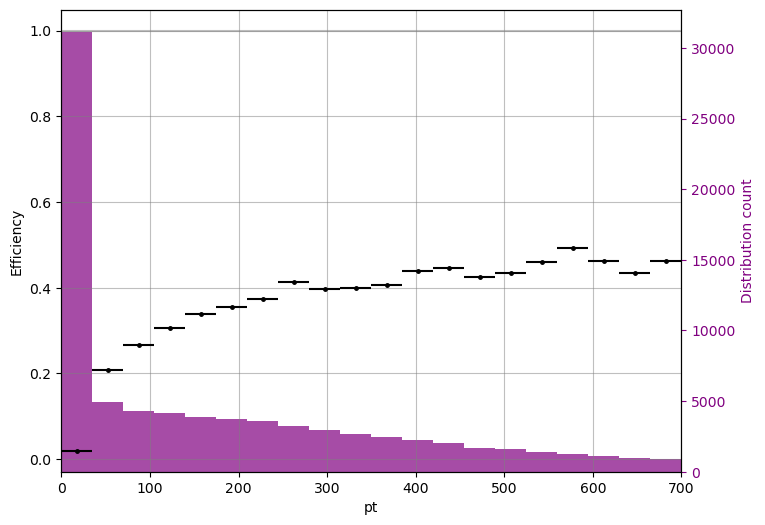

In [38]:
trackEvaluator.plot_histogram(
    column="pt",
    metric_name="efficiency",
    bins=20,
    range=(0, 700)
)

### Categories

Instead of computing metrics across the overall dataframes, it is more common
to compute them in relevant categories of particles, which can be defined using
lambda functions or strings.

A **category** must have a `name` and can optionally have a `label`.
It is applied to the dataframes that contain particles,
that is the `particles` and `candidates` dataframes.

For instance, in the code below, two categories are defined:

- `in_acceptance`: particles with pseudo-rapidity $\eta$ between 2 and 5,
which corresponds to the LHCb detector acceptance.
- `reconstructible_velo`: particles that are reconstructible in the velo subdetector.

In [39]:
in_acceptance = mt.requirement.Category.from_callable(
    name="in_acceptance",
    label="In acceptance",
    callable=lambda df: (df["eta"] > 2) & (df["eta"] < 5),
)
reconstructible_velo =  mt.requirement.Category.from_expr(
    name="reconstructible_velo",
    expr="has_velo",
)
print(f"{in_acceptance=}")
print(f"{reconstructible_velo=}")


in_acceptance=Category[in_acceptance]
reconstructible_velo=Category[reconstructible_velo]


Like matching conditions, categories can be combined into a new category using
one of the 3 boolean operators `&` (and), `|` (or) and `~` (not).

Here is an example:

In [40]:
print(reconstructible_velo & in_acceptance)

(reconstructible_velo) and (in_acceptance)


To redefine the `name` and `label` of a category combined with boolean operators,
you can either change the corresponding attributes directly
or use the `from_category` method. Here's an example:

In [41]:
velo_in_acceptance =  mt.requirement.Category.from_category(
    reconstructible_velo & in_acceptance,
    name="velo_in_acceptance",
    label="Velo, in acceptance",
)
print(velo_in_acceptance)

velo_in_acceptance


When computing a metric, you can specify a category by using the category argument
of the relevant method in `TrackEvaluator`.
For example, to compute the efficiency and plot a histogram of it
for the `velo_in_acceptance` category:

In [42]:
efficiencies = trackEvaluator.compute_metric(
    "efficiency",
    groupby="event_id",
    category=velo_in_acceptance,
)
print(efficiencies)


event
6461281    0.968421
6461282    1.000000
6461283    0.978261
6461284    0.928571
6461285    0.920455
             ...   
7113878    0.961905
7113879    0.958333
7113880    0.987179
7113881    0.979381
7113882    0.916667
Name: efficiency, Length: 99, dtype: float64


((<Figure size 800x600 with 2 Axes>,
  <Axes: xlabel='eta', ylabel='Efficiency'>,
  <Axes: ylabel='Distribution count'>),
 array([586, 647, 659, 694, 639, 673, 674, 677, 624, 701, 608, 631, 602,
        599, 602, 592, 522, 476, 458, 406]),
 array([0.8668942 , 0.90262751, 0.92109256, 0.94236311, 0.93583725,
        0.93907875, 0.9495549 , 0.95273264, 0.94230769, 0.93865906,
        0.95723684, 0.96671949, 0.94352159, 0.96494157, 0.96677741,
        0.96283784, 0.97509579, 0.96008403, 0.98689956, 0.98029557]),
 array([2.00025  , 2.1502205, 2.300191 , 2.4501615, 2.600132 , 2.7501025,
        2.900073 , 3.0500435, 3.200014 , 3.3499845, 3.499955 , 3.6499255,
        3.799896 , 3.9498665, 4.099837 , 4.2498075, 4.399778 , 4.5497485,
        4.699719 , 4.8496895, 4.99966  ]))

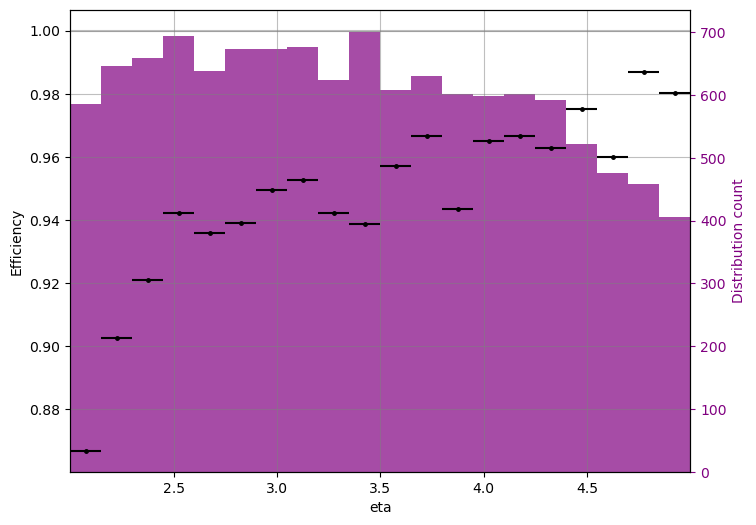

In [43]:
trackEvaluator.plot_histogram(
    "eta",
    "efficiency",
    bins=20,
    category=velo_in_acceptance,
)

Note that `trackEvaluator` caches the filtered dataframes only for one category at once,
so it's more efficient to compute all the metrics for a given category at once.

In the LHCb case, some predefined categories are provided in
`montetracko.lhcb.category` for convenience. This includes:

- `montetracko.lhcb.category.allen_categories`: a list of categories used
in the Allen velo validation sequence
- `montetracko.lhcb.category.velo_categories`: a list of relevant categories
for studying Velo tracking performance

In [44]:
import montetracko.lhcb as mtb

print("Same categories as the ones in the Allen velo validation sequence")
pprint.pprint(mtb.category.allen_categories)
print()
print("Relevant categories to study velo tracking performance")
pprint.pprint(mtb.category.velo_categories)



Same categories as the ones in the Allen velo validation sequence
[Category[velo],
 Category[long],
 Category[long_P>5GeV],
 Category[long_strange],
 Category[long_strange_P>5GeV],
 Category[long_fromB],
 Category[long_fromB_P>5GeV],
 Category[long_electrons],
 Category[long_fromB_electrons],
 Category[long_fromB_electrons_P>5GeV]]

Relevant categories to study velo tracking performance
[Category[velo_reconstructible_acceptance],
 Category[long_reconstructible_acceptance],
 Category[velo_reconstructible_acceptance_no_electrons],
 Category[velo_reconstructible_acceptance_only_no_electrons],
 Category[velo_reconstructible_acceptance_only_electrons],
 Category[long_reconstructible_acceptance_only_electrons],
 Category[velo_only_from_strange],
 Category[velo_from_kshort],
 Category[long_from_kshort]]


## Report

A **reporter**  is an object that defines how to present the performance metrics
for different categories.

There are two pre-defined reporters available:

- `TabReporter`: presents the performance metrics in a table format.
You can specify the metrics to include using `metric_names`, and the presentation
mode using `mode` (e.g., `markdown`, `string`, `latex`, `html`, `csv` or `pandas`)
- `AllenReporter`: presents the performance metrics in the same format as the one used
in the Allen validation sequence.
This reporter does not allow you to customize the metrics to be shown.

Here's an example of how to define and use both reporters:

In [45]:
# Define a TabReporter
tabReporter = mt.TabReporter(
    metric_names=[
        "efficiency",
        "efficiency_per_event",
        "clone_rate",
        "hit_purity_per_candidate",
        "hit_efficiency_per_candidate",
    ],
    mode="markdown",  # can also choose `string`, `latex`, `html` and `csv`
)

# Define an AllenReporter
allenReporter = mt.AllenReporter()

# Print a report with the TabReporter for the velo_categories
print("TabReporter")
trackEvaluator.print_report(tabReporter, categories=mtb.category.velo_categories)
print()
# Print a report with the AllenReporter for all categories
print("AllenReporter")
trackEvaluator.print_report(allenReporter, categories=mtb.category.allen_categories)


TabReporter
| Categories                  | Efficiency   | Average efficiency   | Clone rate   | Average hit purity   | Average hit efficiency   |
|:----------------------------|:-------------|:---------------------|:-------------|:---------------------|:-------------------------|
| Velo                        | 94.61%       | 95.07%               | 3.99%        | 99.35%               | 93.69%                   |
| Long                        | 99.25%       | 99.32%               | 2.82%        | 99.61%               | 96.10%                   |
| Velo, no electrons          | 98.54%       | 98.74%               | 3.11%        | 99.69%               | 95.37%                   |
| Velo only, no electrons     | 97.32%       | 97.72%               | 3.71%        | 99.56%               | 94.27%                   |
| Velo only, only electrons   | 68.87%       | 70.13%               | 11.15%       | 97.30%               | 79.02%                   |
| Long, only electrons        | 97.12%     

You can also use the `trackEvaluator.report` method to obtain a report `string`
instead of printing the report directly.


Note that some metrics, such as the number of ghost tracks and the number of tracks,
are not affected by the choice of a category and must be reported in a table
with no category. Here's an example of how to do that:

In [46]:
trackEvaluator.print_report(
    reporter=mt.TabReporter(
        metric_names=["n_ghosts", "n_tracks", "ghost_rate"],
        mode="markdown",
    ),
)

| Categories   |   # ghosts | # tracks   | Ghost rate   |
|:-------------|-----------:|:-----------|:-------------|
| Everything   |        491 | 24,253     | 2.02%        |


## Many histograms

You can plot various metrics binned across different columns in a grid of plots
using the `plot_histogram` method.

Optionally, you can modify the matplotlib `rcParams` object to customize
the font settings. Here's an example:

((<Figure size 800x600 with 2 Axes>,
  <Axes: xlabel='Efficiency', ylabel='Efficiency'>,
  <Axes: ylabel='Distribution count'>),
 array([1165,  998, 1001,  934,  964,  901,  716,  674,  657,  530,  430,
         412,  336,  296,  227,  164,  171,  157,  151,   99,   81,  102,
          90,   61,   66,   64,   57,   41,   37,   49,   34,   36,   32,
          30,   17,   19,   26,   19,   19,   15]),
 array([0.6       , 0.94589178, 0.97902098, 0.98286938, 0.99170124,
        0.98779134, 0.99162011, 0.98813056, 0.99238965, 0.98490566,
        0.98139535, 0.98300971, 0.98214286, 0.99324324, 0.97797357,
        0.99390244, 1.        , 0.99363057, 0.99337748, 0.97979798,
        0.98765432, 0.97058824, 0.98888889, 1.        , 0.98484848,
        0.984375  , 0.98245614, 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.96875   , 1.        , 1.        ,
        1.        , 0.96153846, 1.        , 1.        , 1.        ]),
 array([   0.,   50.,  100.,  150.,  200.,  250.,  

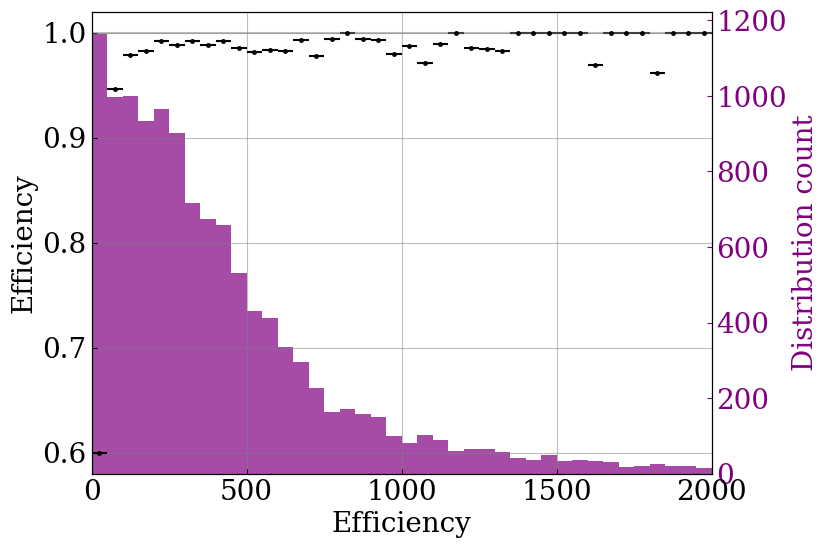

In [52]:
import matplotlib as mpl

# mpl.rcParams.update(**mpl.rcParamsDefault)
mpl.rcParams.update(
    **{
        # Font
        "font.family": "serif",
        # Fontsizes
        "legend.fontsize": 20,
        "axes.titlesize": 24,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "axes.labelsize": 25,
        "font.size": 20,
        # Lines
        "lines.markersize": 6.0,
        "lines.linestyle": "-",
        "lines.linewidth": 1.5,
        # Figure
        "figure.figsize": (8, 6),
        # Ticks
        "xtick.direction": "in",
        "ytick.direction": "in",
    }
)

trackEvaluator.plot_histogram(
    column="pt",
    metric_name="efficiency",
    column_label="Efficiency",
    category=velo_in_acceptance,
    range=(0, 2000),
    bins=40,
)


You can adjust the settings based on your preferences and needs.